In [508]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx
import sklearn.cluster as cluster
import numpy as np
from shapely.geometry import MultiPoint
import seaborn as sns
import statsmodels.api as sm

In [536]:
df = pd.read_pickle('accidents.pkl.gz')
df.set_index('p1', inplace=True)
df

,p36,p37,p2a,weekday(p2a),p2b,p6,p7,p8,p9,p10,...,n,o,p,q,r,s,t,p5a,region,date
p1,,,,,,,,,,,,,,,,,,,,,
2100160001,4,NaN,2016-01-01,5,55,1,1,0,2,1,...,711403.0,NaN,Souhlasnýsesměremúseku,Pomalý,554782.0,451622.0,GN_V0.1UIR-ADR_410,1,PHA,2016-01-01
2100160002,4,NaN,2016-01-01,5,130,1,3,0,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
2100160003,5,NaN,2016-01-01,5,100,1,2,0,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
2100160004,6,NaN,2016-01-01,5,120,9,0,0,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
2100160005,6,NaN,2016-01-01,5,2560,2,0,0,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PHA,2016-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190910224060,3,21030.0,2022-12-28,3,835,5,0,0,2,4,...,NaN,NaN,NaN,NaN,511587.0,NaN,NaN,2,KVK,2022-12-28
190910224148,8,NaN,2022-12-27,2,1900,3,0,6,2,1,...,NaN,NaN,NaN,NaN,538434.0,554553.0,NaN,1,KVK,2022-12-27
190910224288,6,NaN,2022-12-30,5,1000,3,0,3,2,1,...,NaN,NaN,NaN,NaN,560464.0,550817.0,NaN,1,KVK,2022-12-30


In [140]:
df = df.dropna(subset=['d', 'e'])
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.d, df.e), crs="EPSG:5514"
)

In [141]:
gdf.crs.total_bounds

AttributeError: 'CRS' object has no attribute 'total_bounds'

In [142]:
gdf_2 = gdf.copy()
gdf_2 = gdf_2[(gdf_2["region"] == "JHM") & (gdf_2["p10"] == 4)]
gdf_2['date'] = pd.to_datetime(gdf_2['p2a'])
gdf_2.total_bounds

array([-1203601.   , -1219810.382,  -527440.849,  -536506.   ])

In [143]:
gdf_2021 = gdf_2[gdf_2['date'].dt.year == 2021]
gdf_2022 = gdf_2[gdf_2['date'].dt.year == 2022]

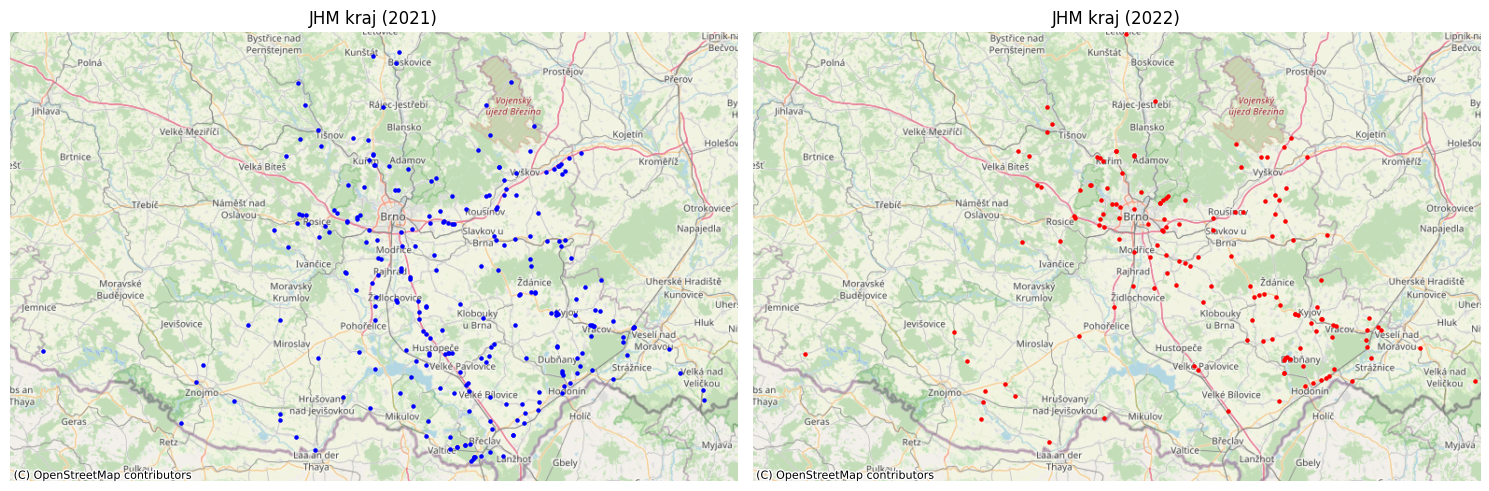

In [144]:
# Convert the CRS to EPSG:3857 for contextily
gdf_2021 = gdf_2021.to_crs(epsg=3857)
gdf_2022 = gdf_2022.to_crs(epsg=3857)

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)

# Plotting for 2021
gdf_2021.plot(ax=axes[0], color='blue', markersize=5)
ctx.add_basemap(axes[0], crs=gdf_2021.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.9)
axes[0].set_title("JHM kraj (2021)")
axes[0].set_axis_off()

# Plotting for 2022
gdf_2022.plot(ax=axes[1], color='red', markersize=5)
ctx.add_basemap(axes[1], crs=gdf_2022.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.9)
axes[1].set_title("JHM kraj (2022)")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

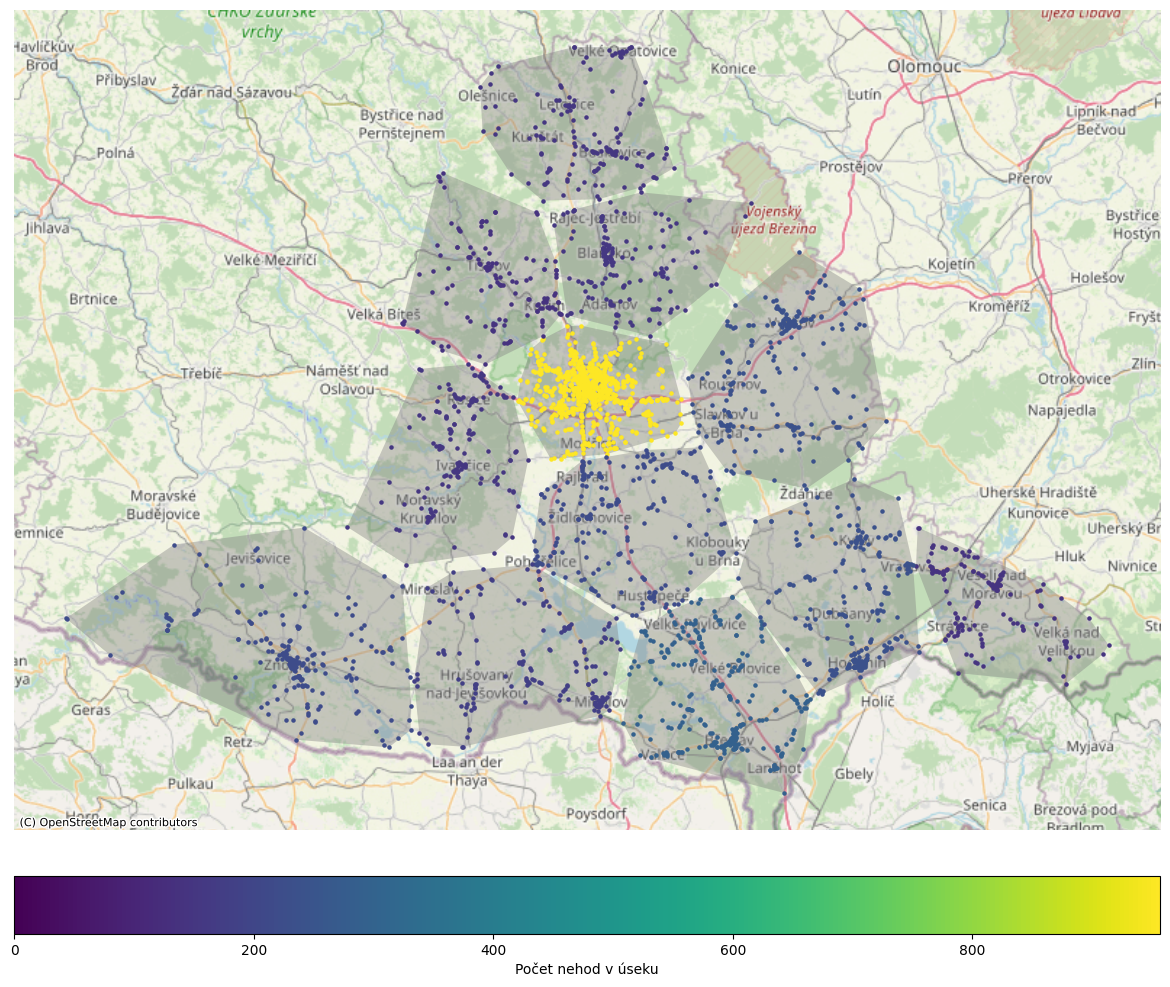

In [145]:

gdf_3 = gdf.copy()
gdf_3 = gdf_3[(gdf_3["region"] == "JHM") & (gdf_3["p11"] >= 4)]

gdf_jhm = gdf[(gdf["region"] == "JHM") & (gdf["date"].dt.year == 2021)]

gdf_jhm = gdf_jhm.to_crs(epsg=3857)
gdf_3 = gdf_3.to_crs(epsg=3857)

gdf_3 = geopandas.clip(gdf_3, gdf_jhm.total_bounds)

coords = gdf_3.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()

kmeans = cluster.KMeans(n_clusters=12, n_init=10)
gdf_3['cluster'] = kmeans.fit_predict(coords)

accident_counts = gdf_3['cluster'].value_counts()
max_accidents = accident_counts.max()

norm = mpl.colors.Normalize(vmin=0, vmax=max_accidents)

colormap = mpl.colormaps['viridis']

gdf_3['color'] = gdf_3['cluster'].apply(lambda x: colormap(norm(accident_counts[x])))

fig, ax = plt.subplots(figsize=(15, 12))

for cluster_id in range(12):
    cluster_gdf = gdf_3[gdf_3['cluster'] == cluster_id]
    if not cluster_gdf.geometry.empty:
        multipoint = MultiPoint(cluster_gdf.geometry.tolist())
        polygon = multipoint.convex_hull 
        gdf_poly = geopandas.GeoDataFrame([polygon], columns=['geometry'], crs=gdf_3.crs)
        gdf_poly.plot(ax=ax, color="gray", alpha=0.4)
        ax.scatter(cluster_gdf.geometry.x, cluster_gdf.geometry.y, color=mpl.colors.to_hex(cluster_gdf['color'].iloc[0]), label=f'Cluster {cluster_id}', s=5)

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
plt.colorbar(sm, ax=ax, label='Počet nehod v úseku', orientation='horizontal', fraction=0.062, pad=0.05)

ctx.add_basemap(ax, crs=gdf_3.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.9)

ax.set_axis_off()

plt.show()

In [537]:
cars_df = df.copy()
cars_df = cars_df[cars_df['p44'].isin([3,4])]
np.sort(cars_df['p45a'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
       55., 56., 58., 59., 60., 61., 62., 63., 64., 65., 68., 69., 70.,
       71., 98., 99., nan])

In [538]:
car_brands_map = {
    1: 'Alfa Romeo',
    2: 'Audi',
    3: 'Avia',
    4: 'BMW',
    5: 'Chevrolet',
    6: 'Chrysler',
    7: 'Citroën',
    8: 'Dacia',
    9: 'Daewoo',
    10: 'DAF',
    11: 'Dodge',
    12: 'Fiat',
    13: 'Ford',
    14: 'GAZ',
    15: 'Ferrari',
    16: 'Honda',
    17: 'Hyundai',
    18: 'IFA',
    19: 'IVECO',
    20: 'Jaguar',
    21: 'Jeep',
    22: 'Lancia',
    23: 'Land Rover',
    25: 'Mazda',
    26: 'Mercedes',
    27: 'Mitshubishi',
    28: 'Moskvič',
    29: 'Nissan',
    30: 'Oltcit',
    31: 'Opel',
    32: 'Peugeot',
    33: 'Porsche',
    34: 'Praga',
    35: 'Renault',
    36: 'Rover',
    37: 'Saab',
    38: 'Seat',
    39: 'Skoda',
    40: 'Scania',
    41: 'Subaru',
    42: 'Suzuki',
    43: 'Tatra',
    44: 'Toyota',
    45: 'Trabant',
    46: 'Vaz',
    47: 'Volkswagen',
    48: 'Volvo',
    49: 'Wartburg',
    50: 'Zastava',
    51: 'AGM',
    52: 'Aro',
    53: 'Austin',
    54: 'Barkas',
    54: 'Daihatsu',
    55: 'Datsun',
    56: 'Destacar',
    58: 'Isuzu',
    59: 'Karosa',
    60: 'Kia',
    61: 'Lublin',
    62: 'MAN',
    63: 'Maserati',
    64: 'Multicar',
    65: 'Pontiac',
    68: 'SsangYong',
    69: 'Talbot',
    70: 'Taz',
    71: 'Zaz',
    98: 'Jiné vyrobené v ČR',
    99: 'Jiné vyrobené v zahraničí',
}

In [539]:
# Find the row with the maximum damage cost
cars_df['technical_issue'] = cars_df['p10'] == 7

In [540]:
def convert_two_digit_year_to_four_digit(year_str, cutoff='23'):
    if year_str is np.nan:
        return np.nan
    
    if year_str == 'XX':
        return np.nan
    # Determine the century based on the cutoff
    if year_str >= cutoff:
        century = '19'
    else:
        century = '20'
    return int(century + year_str)

In [541]:
cars_df.dropna(subset=['p47'], inplace=True)
cars_df['car_year'] = cars_df['p47'].apply(convert_two_digit_year_to_four_digit)
cars_df['accident_year'] = cars_df['date'].dt.year
cars_df['car_age'] = cars_df['accident_year'] - cars_df['car_year']

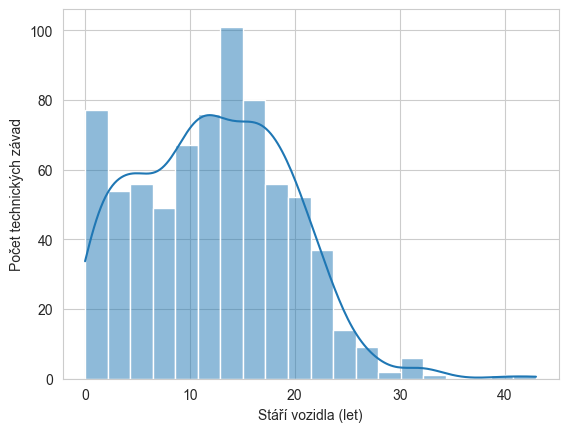

In [507]:

tech_acc = cars_df[cars_df['technical_issue'] == True]

sns.histplot(data=tech_acc, x='car_age', kde=True, bins=20)

plt.xlabel('Stáří vozidla (let)')
plt.ylabel('Počet technických závad')
plt.savefig('tech_acc.png', dpi=300, bbox_inches='tight')
plt.show()


In [542]:
print(len(cars_df))
print(len(tech_acc))
print(len(tech_acc) / len(cars_df) * 100)
print(cars_df['p53'].mean())

439284
739
0.1682282987771009
407.61607069686124


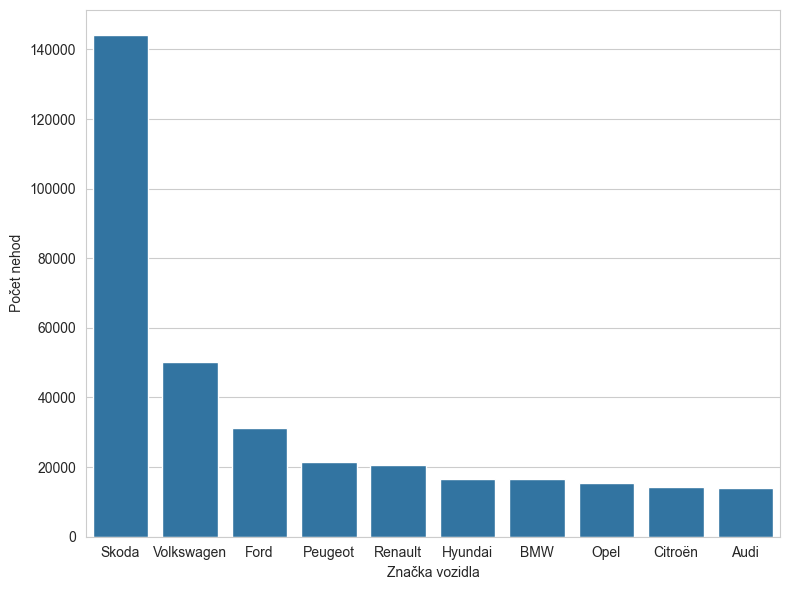

In [543]:
accidents_cnt_by_brand = cars_df['p45a'].value_counts().head(10)
accidents_cnt_by_brand = accidents_cnt_by_brand.rename(car_brands_map)

# Plotting with Seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=accidents_cnt_by_brand.index, y=accidents_cnt_by_brand.values, ax=ax)

plt.ylabel('Počet nehod')
plt.xlabel('Značka vozidla')
plt.tight_layout()
fig.savefig('accidents_by_brand.png', dpi=300)
plt.show()

In [544]:
brand_percentages = cars_df['p45a'].value_counts(normalize=True).head(10)
brand_percentages = brand_percentages.rename(car_brands_map)
brand_percentages

p45a
Skoda         0.328094
Volkswagen    0.114082
Ford          0.071052
Peugeot       0.049014
Renault       0.047095
Hyundai       0.038064
BMW           0.037980
Opel          0.034871
Citroën       0.032373
Audi          0.031592
Name: proportion, dtype: float64

In [369]:
tech_issue_type_map = {
    601: 'Závada řízení',
    602: 'Závada provozní brzdy',
    603: 'Závada parkovací brzdy',
    604: 'Opotřebení běhounu pláště',
    605: 'Defekt pneumatiky (průraz, únik vzduchu)',
    606: 'Závada osvětlení',
    607: 'Nepřipojená/poškozená hadice pro brzdovou soustavu přívěsu',
    608: 'Nesprávné uložení nákladu',
    609: 'Upadnutí, ztráta kola vozidla',
    610: 'Zablokování kol v důsledku mechanické závady',
    611: 'Lom závěsu kola',
    612: 'Nezajištěná/poškozená bočnice',
    613: 'Závada závěsu pro přívěs',
    614: 'Utržená spojovací hřídel',
    615: 'Jiná technická závada',
}

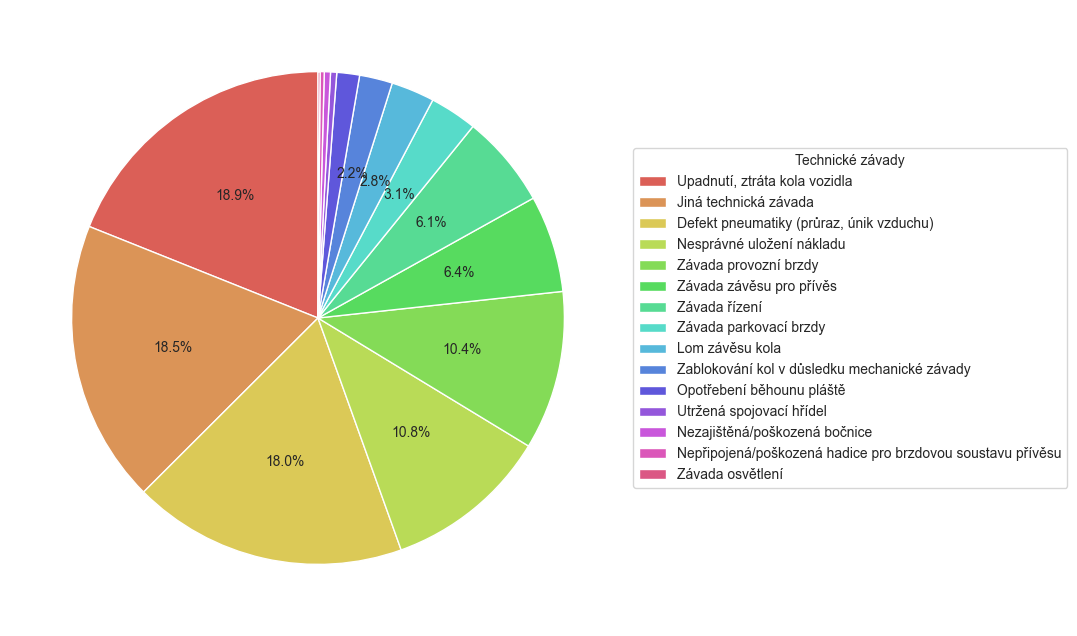

In [503]:
def custom_autopct(pct):
    return '{:.1f}%'.format(pct) if pct > 2 else ''

tech_issues_by_type = tech_acc['p12'].value_counts()
tech_issues_by_type = tech_issues_by_type.rename(tech_issue_type_map)

# Data for the pie chart
sizes = tech_issues_by_type.values
labels = tech_issues_by_type.index

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, text1, text2 = plt.pie(sizes, labels=None, autopct=custom_autopct, startangle=90, colors=sns.color_palette("hls", len(sizes)))

# Create the legend
plt.legend(wedges, labels, title="Technické závady", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig('tech_issues_by_type.png', bbox_inches="tight")
plt.show()

In [545]:
accidents_cnt_by_brand


p45a
Skoda         144126
Volkswagen     50114
Ford           31212
Peugeot        21531
Renault        20688
Hyundai        16721
BMW            16684
Opel           15318
Citroën        14221
Audi           13878
Name: count, dtype: int64

In [444]:
car_idx = cars_df['p45a'].value_counts().head(10).index
tech_issues_by_brand = tech_acc['p45a'].value_counts().reindex(car_idx)
tech_issues_by_brand = tech_issues_by_brand.rename(car_brands_map)
tech_issues_by_brand

p45a
Skoda         201
Volkswagen    106
Ford           69
Peugeot        34
Renault        29
Hyundai        18
BMW            20
Opel           29
Citroën        23
Audi           19
Name: count, dtype: int64

In [447]:
percentage = tech_issues_by_brand / accidents_cnt_by_brand * 100
percentage

p45a
Skoda         0.139755
Volkswagen    0.212144
Ford          0.221559
Peugeot       0.158287
Renault       0.140606
Hyundai       0.107907
BMW           0.120142
Opel          0.189990
Citroën       0.161949
Audi          0.137234
Name: count, dtype: float64

In [448]:
mean_damage_costs_by_brand = cars_df.groupby('p45a')['p53'].mean().reindex(car_idx)
mean_damage_costs_by_brand = mean_damage_costs_by_brand.rename(car_brands_map)
mean_damage_costs_by_brand

p45a
Skoda         388.434346
Volkswagen    381.862647
Ford          337.806152
Peugeot       319.249721
Renault       303.861091
Hyundai       419.220670
BMW           704.682345
Opel          300.389872
Citroën       331.039501
Audi          583.378043
Name: p53, dtype: float64

In [458]:
deaths_by_brand = tech_acc.groupby('p45a')['p13a'].sum().reindex(car_idx)
injuries_by_brand = tech_acc.groupby('p45a')['p13b'].sum().reindex(car_idx)
injuries_by_brand = deaths_by_brand + injuries_by_brand + tech_acc.groupby('p45a')['p13c'].sum().reindex(car_idx)

injuries_by_brand = injuries_by_brand.rename(car_brands_map)
injuries_by_brand

p45a
Skoda         55
Volkswagen    18
Ford          13
Peugeot       13
Renault       17
Hyundai        8
BMW           12
Opel          10
Citroën       10
Audi          11
dtype: int64

In [534]:
cars_df_copy = cars_df.copy()

cars_df_copy['technical_issue'] = cars_df_copy['technical_issue'].astype(int)
cars_df_copy['intercept'] = 1

cars_df_copy = cars_df_copy.dropna(subset=['car_age'])
print(cars_df_copy['car_age'].unique())

X = cars_df_copy[['car_age', 'intercept']]
Y = cars_df_copy['technical_issue']

logit_model = sm.Logit(Y, X)
result = logit_model.fit()

print(result.summary())

[ 1.  8. 10. 11.  5.  4.  9.  6.  7.  3. 12. 20.  2. 14. 17. 13. 16. 19.
 23. 18. 21. 15. 22.  0. 27. 24. 25. 29. 26. 28. 45. 30. 34. 37. 31. 43.
 33. 32. 53. 36. 40. 42. 41. 35. 39. 49. 38. 44. 47. 46. 51. 78. 74. 83.
 48. 68. 57. 50. 56. 54. 84. 52. 87. 76. 99. 70. 58. 98. 69. 55.]
Optimization terminated successfully.
         Current function value: 0.012332
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:        technical_issue   No. Observations:               438199
Model:                          Logit   Df Residuals:                   438197
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Dec 2023   Pseudo R-squ.:                0.009718
Time:                        12:22:59   Log-Likelihood:                -5404.0
converged:                       True   LL-Null:                       -5457.0
Covariance Type:            nonrobust   LLR p-value:       